# Описание проекта

**Контекст**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

# Описание данных

**Данные для первой части**

Файл /datasets/hypothesis.csv. 
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл /datasets/orders.csv.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
# Снимаем ограничение на ширину таблиы
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# Загрузка данных

In [2]:
#Чтение файла в переменную
try:       # Локальный путь
    hypothesis=pd.read_csv('hypothesis.csv')
    orders=pd.read_csv('orders.csv')
    visitors=pd.read_csv('visitors.csv')
except:        # Серверный путь
    hypothesis=pd.read_csv('/datasets/hypothesis.csv')
    orders=pd.read_csv('/datasets/orders.csv')
    visitors=pd.read_csv('/datasets/visitors.csv')

In [3]:
# Приводим даты к правильному типу
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
hypothesis.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')

In [6]:
hypothesis.columns=('hypothesis', 'reach', 'impact', 'confidence', 'efforts')

In [7]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [9]:
orders.columns=('orderId', 'userId', 'date', 'revenue', 'group')

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
orderId    1197 non-null int64
userId     1197 non-null int64
date       1197 non-null datetime64[ns]
revenue    1197 non-null int64
group      1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [13]:
# подсчёт явных дубликатов
orders.duplicated().sum()

0

In [14]:
# подсчёт явных дубликатов
visitors.duplicated().sum()

0

# Приоритизация гипотез

In [15]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


## Фреймворк ICE

In [16]:
hypothesis['ICE']=hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


## Фреймворк RICE

In [17]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


# Вывод

Фреймворк ICE: Наиболее перспективные гипотезы 8, 0, 7

Фреймворк RICE: Наиболее перспективные гипотезы 7, 2, 0

Метод RICE отличается от метода ICE тем, что,  в нем есть дополнительный параметр **reach**, который учтывает охват пользователей. В данном случае охват 7 гипотезы самый большой, поэтому он изменил рейтинг.

# Анализ A/B-теста

In [18]:
# Проверим, есть ли пользователи попавшие в обе группы.
orders.groupby('userId').agg({'group':'nunique'}).query('group>1').count()

group    58
dtype: int64

Есть 58 перекрестных пользователей, группы разделены несовсем корректно

In [19]:
orders.head(5)    

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [20]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [21]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [22]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [23]:

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [24]:

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [25]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

Названия столбцов данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [26]:
data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


## График кумулятивной выручки по группам

C:\Users\SanSanix\anaconda3\envs\praktikum_env_win_new\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


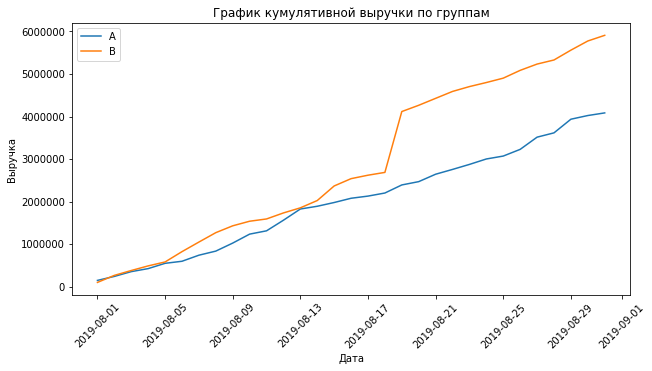

In [27]:
# Строим график выручки группы А
plt.figure(figsize=(10, 5));
plt.plot(data['date'], data['revenueCummulativeA'], label='A');

# Строим график выручки группы B
plt.plot(data['date'], data['revenueCummulativeB'], label='B');

plt.legend()
plt.title('График кумулятивной выручки по группам');
plt.ylabel("Выручка");
plt.xticks(rotation=45);
plt.legend();
plt.xlabel("Дата");


Группа В стабильно лучше, но есть скачек, возможно вызванный выбросами.

## график кумулятивного среднего чека по группам

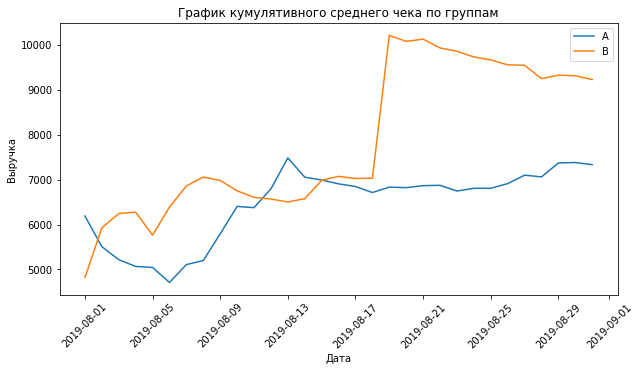

In [28]:
# Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
plt.figure(figsize=(10, 5));
plt.plot(data['date'], data['revenueCummulativeA']/data['ordersCummulativeA'], label='A');

plt.plot(data['date'], data['revenueCummulativeB']/data['ordersCummulativeB'], label='B');

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend();
plt.xlabel("Дата");
plt.show();

Графики не равномерные, в группе В также виден сильный скачек.
Средний чек после скачка в группе В падает.

## График относительного изменения кумулятивного среднего чека группы B к группе A

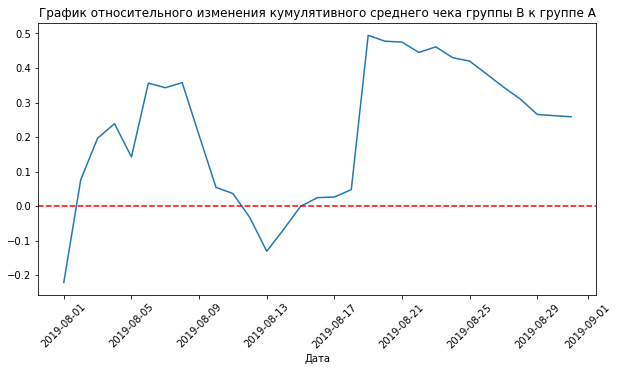

In [29]:
plt.figure(figsize=(10, 5));
# cтроим отношение средних чеков
plt.plot(data['date'], (data['revenueCummulativeB']/data['ordersCummulativeB'])/(data['revenueCummulativeA']/data['ordersCummulativeA'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');
plt.axhline(y=0, color='red', linestyle='--');
plt.xticks(rotation=45);
plt.xlabel("Дата");
plt.show();

График сильно скачет. Со средним чеком ситуация пока не понятная, вильно влияют выбросы.

## График кумулятивной конверсии по группам

In [30]:
# считаем кумулятивную конверсию
data['conversionA'] = data['ordersCummulativeA']/data['visitorsCummulativeA']
data['conversionB'] = data['ordersCummulativeB']/data['visitorsCummulativeB']

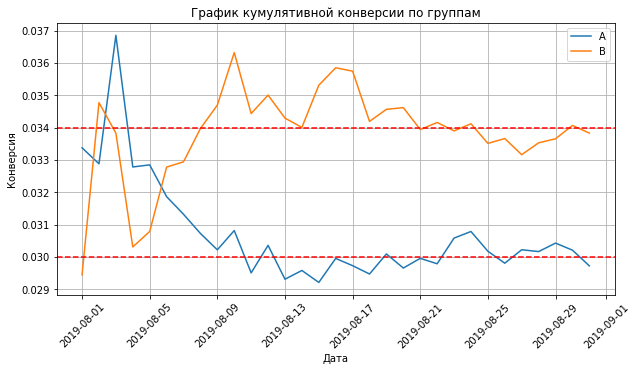

In [31]:
plt.figure(figsize=(10, 5));
plt.grid()
plt.plot(data['date'], data['conversionA'], label='A')
plt.plot(data['date'], data['conversionB'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Конверсия")
plt.xticks(rotation=45)
plt.legend()
plt.axhline(y=0.034, color='red', linestyle='--');
plt.axhline(y=0.03, color='red', linestyle='--');
plt.xlabel("Дата");
plt.show()


Конверсия группы В выше, можно сказать, что конверсии вышли на свои значения, и колеблются вокруг них.

## График относительного изменения кумулятивной конверсии группы B к группе A

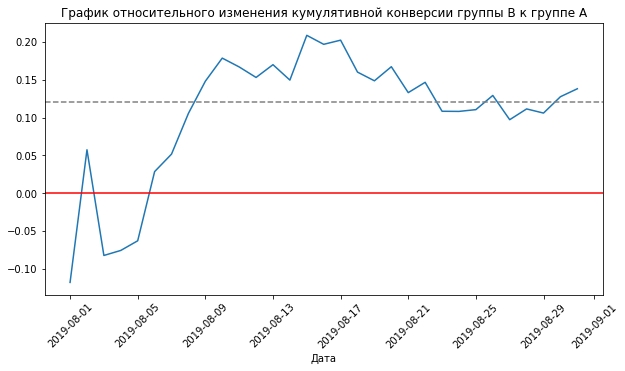

In [32]:

plt.figure(figsize=(10, 5));
plt.plot(data['date'], data['conversionB']/data['conversionA']-1);
plt.axhline(y=0.12, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='red', linestyle='-')
plt.xticks(rotation=45);
plt.xlabel("Дата");
plt.show() 

График подтверждает предыдущий, конверсия группы В стабильно лучше.

## Точечный график количества заказов по пользователям

In [33]:
orders.head(5)

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [34]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


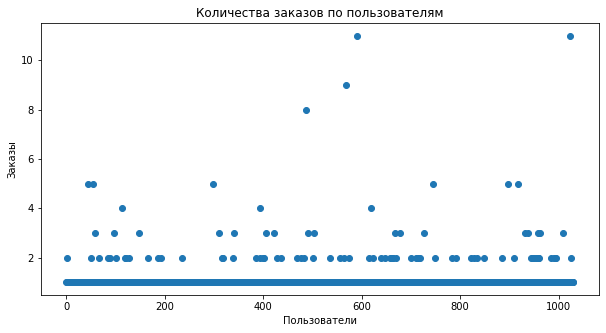

In [35]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(10, 5));
plt.scatter(x_values, ordersByUsers['orders']); 
plt.title('Количества заказов по пользователям');
plt.ylabel("Заказы");
plt.xlabel("Пользователи");
plt.show();

В основном покупают 1 раз, но есть выбросы.

##  95-й и 99-й перцентили количества заказов на пользователя

In [36]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И 1% пользователей заказывали более 4 раз.

Выбираем границу аномальных заказов >2


## Точечный график стоимостей заказов

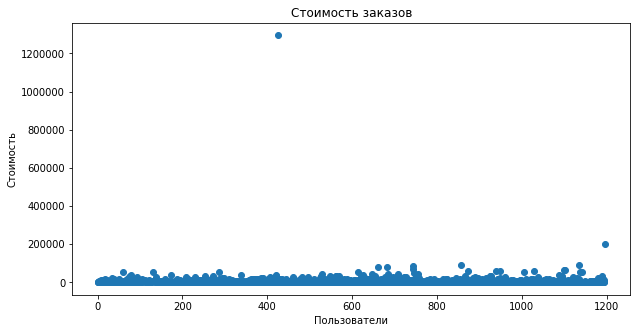

In [37]:
plt.figure(figsize=(10, 5));
x_values = pd.Series(range(0,len(orders['revenue'])));
plt.scatter(x_values, orders['revenue']) 
plt.title('Стоимость заказов');
plt.ylabel("Стоимость");
plt.xlabel("Пользователи");
plt.show();

In [38]:
df=orders.query('revenue>200000')
df

,orderId,userId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


Эти выбросы принадлежат группе В, отсюда и скачки на графиках выше.

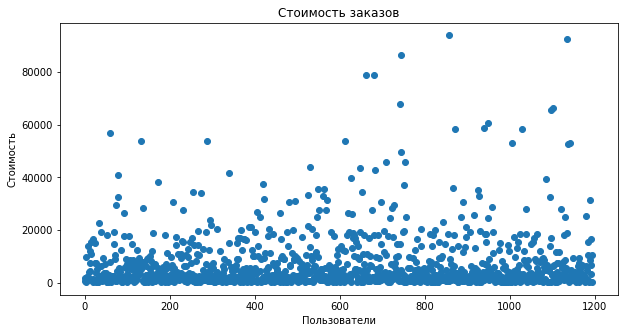

In [39]:
df=orders.query('revenue<200000')

plt.figure(figsize=(10, 5));
x_values = pd.Series(range(0,len(df['revenue'])));
plt.scatter(x_values, df['revenue']) 
plt.title('Стоимость заказов');
plt.ylabel("Стоимость");
plt.xlabel("Пользователи");
plt.show();

## 95-й и 99-й перцентили стоимости заказов

In [40]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233.2 рублей.

Выбираем границу аномальной стоимости заказа >58233.2

## Статистическая значимость различий в конверсии между группами по «сырым» данным

Сформулируем гипотезы.

Нулевая: различий в конверсии между группами по «сырым» данным нет.

Альтернативная: различия в конверсии между группами по «сырым» данным есть.

In [41]:
alpha=0.05

In [42]:
# Посчитаем статистическую значимость различия в конверсии между группами.

# пользователи , которые заказывали хотя бы 1 раз, число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

p_value=st.mannwhitneyu(sampleA, sampleB)[1]
print('pvalue:', round(p_value, 4))

# Выведем относительный прирост конверсии группы B
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 

pvalue: 0.0084
0.138


In [43]:
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


### Вывод
По «сырым» данным различия в конверсии групп A и B есть.

Относительное превосходство группы B равно 13.8%

## Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы.

Нулевая гипотеза: различий в среднем чеке между группами по «сырым» данным нет.

Альтернативная гипотеза: различия в среднем чеке между группами по «сырым» данным есть.

In [44]:
p_value=st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('pvalue:', round(p_value, 4))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

pvalue: 0.3646
0.259


In [45]:
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


### Вывод

По «сырым» данным различий в среднем чеке групп A и B нет.

Однако относительный выйгрыш группы B равен 25.9% 


## Статистическая значимость различий в конверсии между группами по «очищенным» данным

In [46]:
# Отсеим пользователей совершивших более 2 покупок
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
# Отсеим пользователей совершивших заказы стоимостью > 58233.2
usersWithExpensiveOrders = orders[orders['revenue'] > 58233.2]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
Name: userId, dtype: int64
(31,)


Отсеяли 31 аномальных пользователей.

Сформулируем гипотезы.

Нулевая: различий в конверсии между группами по «очищенным » данным нет.

Альтернативная: различия в конверсии между группами по «очищенным » данным есть.

In [47]:
# Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным.
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [48]:
p_value=st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print('pvalue:', round(p_value, 4))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

pvalue: 0.005
0.174


In [49]:
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


### Вывод
По «очищенным» данным различия в конверсии групп A и B есть.

Относительное превосходство группы B равен 17.4%

## Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы.

Нулевая гипотеза: различий в среднем чеке между группами по «очищенным» данным нет.

Альтернативная гипотеза: различия в среднем чеке между группами по «очищенным» данным есть.

In [50]:
p_value= st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
print('pvalue:', round(p_value, 4))
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

pvalue: 0.3989
-0.020


In [51]:
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


### Вывод

По «очищенным» данным различий в среднем чеке групп A и B нет.

Относительный пройгрыш группы B равен 2% 

## Вывод

Задачи проекта: приоритизировать гипотезы, провести А/В-тесты и сделать выводы о потенциальном изменении.

- Были загружены и предобработаны данные.
- При помощи фреймворков RICE и ICE, приоритизированы гипотезы для увеличения выручки.
- Оценены кумулятивные метрики и графики относительного различия двух групп.
- Проведены А/В-тесты.

По результатам исследования, можно сделать следующие выводы:

- Есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий. Группа В лучше.

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.

Средний чек покупателя не увеличился, но увеличилась конверсия, те количество новых покупателей, значит, прибыль магазина увеличилась. Считаю, что, можно остановить тест и зафиксировать победу группы В.

Исследуемая гипотеза рекомендуется к внедрению.